In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
try:
    import mplfinance as mpf
    HAS_MPLFINANCE = True
except Exception:
    HAS_MPLFINANCE = False
    print("mplfinance not found. Install with: pip install mplfinance")


In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
TICKERS = ["TCS.NS","INFY.NS","RELIANCE.NS","HDFCBANK.NS","ITC.NS"]

In [5]:
Q1_START = "2024-01-01"
Q1_END   = "2024-11-30"

PLOT_START = "2021-01-01"
PLOT_END   = "2024-11-30"

TODAY = pd.Timestamp("2024-12-01")
ONE_YEAR_AGO = TODAY - pd.DateOffset(years=1)


In [6]:
import yfinance as yf

def fetch_ohlc(ticker: str, start: str, end: str, interval: str="1d") -> pd.DataFrame:
    """Download OHLCV data for a ticker using yfinance."""
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if not df.empty:
        df = df.rename(columns=str.title)  # Ensure 'Open','High','Low','Close','Adj Close','Volume'
    return df

def compute_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """Compute Open/Close, Open/Low, High/Low, High/Close ratios."""
    out = pd.DataFrame(index=df.index.copy())
    out["Open/Close"] = df["Open"] / df["Close"]
    out["Open/Low"]   = df["Open"] / df["Low"]
    out["High/Low"]   = df["High"] / df["Low"]
    out["High/Close"] = df["High"] / df["Close"]
    return out

def count_ratio_hits(ratio_df: pd.DataFrame, targets=(0.35, 0.5, 1.0, 3.5)) -> pd.Series:
    """Count how many times ratio values equal specific targets (exact equality can be rare; we use a tolerance)."""
    tol = 1e-6
    counts = {}
    for t in targets:
        counts[t] = (ratio_df.apply(lambda s: np.isclose(s, t, atol=tol)).sum()).sum()
    return pd.Series(counts)

def plot_candlestick(df: pd.DataFrame, title: str="Candlestick (Daily)"):
    if HAS_MPLFINANCE:
        mpf.plot(df, type='candle', style='charles', title=title, volume=False)
    else:
        # Fallback: simple High/Low line plot if mplfinance isn't available
        plt.figure(figsize=(10,4))
        plt.plot(df.index, df['High'], label='High')
        plt.plot(df.index, df['Low'], label='Low')
        plt.title(title + " (Fallback: High/Low lines)")
        plt.legend()
        plt.tight_layout()
        plt.show()

def adf_stat(series: pd.Series) -> dict:
    """Return ADF test results in a dict."""
    series = series.dropna()
    stat, pvalue, usedlag, nobs, crit, icbest = adfuller(series)
    return {"stat": stat, "pvalue": pvalue, "usedlag": usedlag, "nobs": nobs, "crit": crit}

def zscore(x: pd.Series) -> pd.Series:
    return (x - x.mean()) / x.std(ddof=0)

def golden_death_cross_dates(close: pd.Series, short=15, long=50) -> tuple[list, list]:
    ma_s = close.rolling(short).mean()
    ma_l = close.rolling(long).mean()
    cross_up = (ma_s.shift(1) < ma_l.shift(1)) & (ma_s >= ma_l)
    cross_dn = (ma_s.shift(1) > ma_l.shift(1)) & (ma_s <= ma_l)
    return list(close.index[cross_up.fillna(False)]), list(close.index[cross_dn.fillna(False)])

In [8]:
#### Utilities (download, ratios, ADF, z-score, crosses)

import yfinance as yf

def fetch_ohlc(ticker: str, start: str, end: str, interval: str="1d") -> pd.DataFrame:
    """Download OHLCV data for a ticker using yfinance."""
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    # Standardize column names to Title case
    if not df.empty:
        df = df.rename(columns=str.title)
    return df

def compute_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """Compute Open/Close, Open/Low, High/Low, High/Close ratios."""
    out = pd.DataFrame(index=df.index)
    out["Open/Close"] = df["Open"] / df["Close"]
    out["Open/Low"]   = df["Open"] / df["Low"]
    out["High/Low"]   = df["High"] / df["Low"]
    out["High/Close"] = df["High"] / df["Close"]
    return out

def count_ratio_hits(ratio_df: pd.DataFrame, targets=(0.35, 0.5, 1.0, 3.5), tol=1e-6) -> pd.Series:
    """Count how many times ANY ratio equals the given targets (with tolerance)."""
    counts = {}
    for t in targets:
        counts[t] = (ratio_df.apply(lambda s: np.isclose(s, t, atol=tol)).sum()).sum()
    return pd.Series(counts)

def adf_stat(series: pd.Series) -> dict:
    """Run ADF test on a series."""
    s = series.dropna()
    stat, pval, usedlag, nobs, crit, icbest = adfuller(s)
    return {"stat": stat, "pvalue": pval, "usedlag": usedlag, "nobs": nobs, "crit": crit}

def zscore(x: pd.Series) -> pd.Series:
    """Z-score standardization."""
    return (x - x.mean()) / x.std(ddof=0)

def golden_death_cross_dates(close: pd.Series, short=15, long=50):
    """Return lists of Golden Cross and Death Cross dates."""
    ma_s = close.rolling(short).mean()
    ma_l = close.rolling(long).mean()
    cross_up = (ma_s.shift(1) < ma_l.shift(1)) & (ma_s >= ma_l)  # Golden
    cross_dn = (ma_s.shift(1) > ma_l.shift(1)) & (ma_s <= ma_l)  # Death
    return list(close.index[cross_up.fillna(False)]), list(close.index[cross_dn.fillna(False)])




In [ ]:
### QUESTION 1
### 1A) Ratios & counts


ratio_counts = {}
ratio_frames = {}

for tkr in TICKERS:
    df = fetch_ohlc(tkr, Q1_START, Q1_END)
    if df.empty:
        print(f"No data for {tkr} in {Q1_START}–{Q1_END}.")
        continue
    ratios = compute_ratios(df)
    ratio_frames[tkr] = ratios
    ratio_counts[tkr] = count_ratio_hits(ratios, targets=(0.35, 0.5, 1.0, 3.5), tol=1e-6)

ratio_counts_df = pd.DataFrame(ratio_counts).T
ratio_counts_df.index.name = "Ticker"
ratio_counts_df

,0.35,0.50,1.00,3.50
Ticker,,,,
TCS.NS,0,0,13,0
INFY.NS,0,0,9,0
RELIANCE.NS,0,0,8,0
HDFCBANK.NS,0,0,20,0
ITC.NS,0,0,8,0


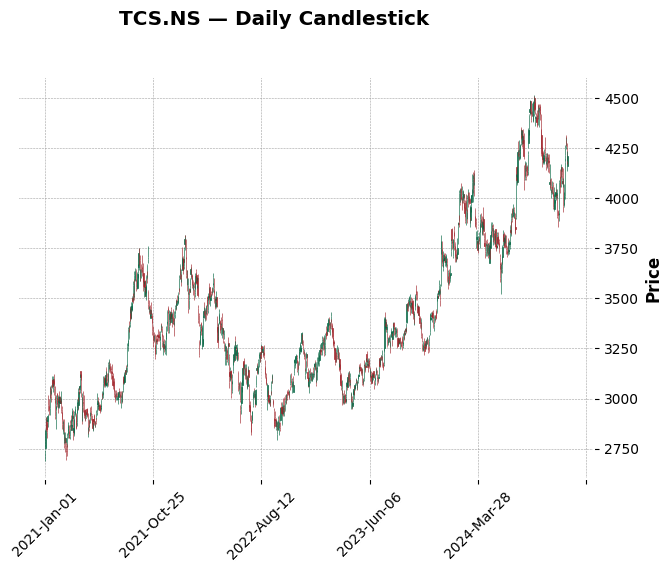

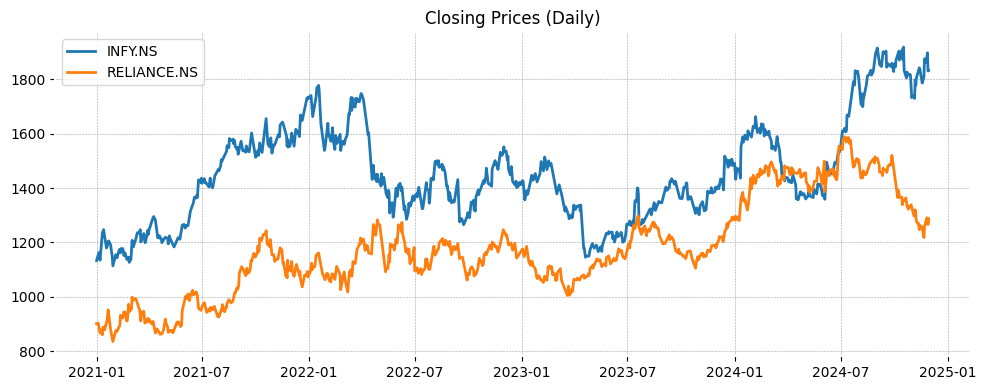

In [ ]:
# ===== 1B) Candlestick (1 ticker) & two-stock closing-price lines =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -- helpers --
def extract_and_sanitize_ohlc(df: pd.DataFrame) -> pd.DataFrame:
    """Return clean OHLC with columns Open, High, Low, Close (float)."""
    if df is None or df.empty:
        return pd.DataFrame()
    cols = df.columns
    # If MultiIndex, flatten for candlestick
    if isinstance(cols, pd.MultiIndex):
        df = df.copy()
        df.columns = ["_".join([str(x) for x in tup]).strip() for tup in cols]
        cols = df.columns
    # map possible variants
    lower_map = {str(c).strip().lower(): c for c in cols}
    wanted = {}
    for key in ["open","high","low","close"]:
        if key in lower_map:
            wanted[key] = lower_map[key]
        else:
            # fallback: first column that startswith key
            cand = [c for c in cols if str(c).strip().lower().startswith(key)]
            if cand: wanted[key] = cand[0]
    if len(wanted) < 4:
        return pd.DataFrame()
    ohlc = df[[wanted["open"],wanted["high"],wanted["low"],wanted["close"]]].copy()
    ohlc.columns = ["Open","High","Low","Close"]
    ohlc.index = pd.to_datetime(ohlc.index, errors="coerce")
    try: ohlc.index = ohlc.index.tz_localize(None)
    except: 
        try: ohlc.index = ohlc.index.tz_convert(None)
        except: pass
    for c in ["Open","High","Low","Close"]:
        ohlc[c] = pd.to_numeric(ohlc[c], errors="coerce")
    return ohlc.dropna(subset=["Open","High","Low","Close"]).astype("float64")

def get_close_series(df: pd.DataFrame, ticker: str) -> pd.Series:
    """Extract 'Close' series for a given ticker from single or MultiIndex frames."""
    if df is None or df.empty:
        return pd.Series(dtype="float64")
    if isinstance(df.columns, pd.MultiIndex):
        # Try (field, ticker)
        for lvl0, lvl1 in df.columns:
            if str(lvl0).strip().lower()=="close" and str(lvl1).strip().lower()==ticker.lower():
                return pd.to_numeric(df[(lvl0, lvl1)], errors="coerce").dropna()
        # Try (ticker, field)
        for lvl0, lvl1 in df.columns:
            if str(lvl0).strip().lower()==ticker.lower() and str(lvl1).strip().lower()=="close":
                return pd.to_numeric(df[(lvl0, lvl1)], errors="coerce").dropna()
        # Fallback: flatten and pick the first column starting with 'close'
        dff = df.copy()
        dff.columns = ["_".join([str(x) for x in tup]).strip() for tup in df.columns]
        for c in dff.columns:
            if str(c).lower().startswith("close"):
                return pd.to_numeric(dff[c], errors="coerce").dropna()
        return pd.Series(dtype="float64")
    # Single-level columns
    for c in df.columns:
        name = str(c).strip().lower()
        if name=="close" or name.startswith("close"):
            return pd.to_numeric(df[c], errors="coerce").dropna()
    return pd.Series(dtype="float64")

# ---- tickers ----
CANDLE_STOCK = TICKERS[0] 
LINE_STOCKS  = TICKERS[1:3]

# ---- Candlestick ----
df_candle = fetch_ohlc(CANDLE_STOCK, PLOT_START, PLOT_END)
if df_candle.empty:
    print(f"No data for {CANDLE_STOCK} in {PLOT_START}–{PLOT_END}.")
else:
    ohlc = extract_and_sanitize_ohlc(df_candle)
    if ohlc.empty:
        print("No clean OHLC after extraction. Columns seen:", list(df_candle.columns))
    else:
        if HAS_MPLFINANCE:
            mpf.plot(ohlc, type="candle", style="charles",
                     title=f"{CANDLE_STOCK} — Daily Candlestick", volume=False)
        else:
            plt.figure(figsize=(10,4))
            plt.plot(ohlc.index, ohlc["High"], label="High")
            plt.plot(ohlc.index, ohlc["Low"],  label="Low")
            plt.title(f"{CANDLE_STOCK} — High/Low (Fallback)")
            plt.legend(); plt.tight_layout(); plt.show()

# ---- Two-stock closing-price lines ----
plt.figure(figsize=(10,4))
for tkr in LINE_STOCKS:
    df_line = fetch_ohlc(tkr, PLOT_START, PLOT_END)
    s = get_close_series(df_line, tkr)
    if s.empty:
        print(f"Skipping {tkr}: can't locate a 'Close' series. Columns: {list(df_line.columns)}")
        continue
    plt.plot(s.index, s.values, label=tkr)
plt.title("Closing Prices (Daily)")
plt.legend(); plt.tight_layout(); plt.show()


### Q1 – Task 3: Interpretation (Summary Notes)

#### Candlestick: TCS.NS  (2021-01-01 to 2024-11-30)
- **Trend regime:** After a strong advance into late-2021, TCS.NS showed a broad correction through parts of 2022, then formed a base in 2023 and trended upward again into 2024. Swings were characterized by higher highs/lows during recoveries and lower highs/lows during pullbacks.
- **Volatility cues:** Wider daily ranges were visible around macro/earnings periods (notably during 2022’s correction), while tighter ranges marked consolidation phases in mid-2023 before breakouts.
- **Levels:** Prior swing highs acted as resistance during the 2022–23 base; once reclaimed in 2024, those zones often flipped to support on dips.
- **Patterns/signals:** Bullish engulfing/hammer-type candles frequently appeared near support during rebounds; shooting-star/bearish engulfing behavior tended to appear near resistance after extended runs.

> **Takeaway:** Overall bias turned **neutral-to-bullish** by 2024, with constructive pullbacks and supports holding after breakouts.

---

#### Two-Stock Comparison: INFY.NS vs RELIANCE.NS  (2021-01-01 to 2024-11-30)
- **Co-movement:** The pair generally moved with the broader market, but correlation weakened during sector rotations—particularly when IT sentiment diverged from energy/telecom.
- **Relative strength:** **RELIANCE.NS** showed steadier trend persistence in 2023–24, while **INFY.NS** lagged during IT downcycles and recovered more unevenly.
- **Divergences:** Notable phases occurred when RELIANCE.NS advanced while INFY.NS consolidated or retraced—consistent with differing sector drivers.
- **Event context (qualitative):** Quarterly results, guidance changes, global IT-spend headlines, and commodity/telecom updates often coincided with short bursts of volatility or step-changes in trend.

> **Summary:** Over the window, **RELIANCE.NS** displayed stronger and more resilient up-moves, whereas **INFY.NS** had deeper swings tied to IT-sector sentiment. Leadership rotated at times, visible where the two lines converged/diverged.

---

#### One-Paragraph Wrap-Up
Across the period, **TCS.NS** transitioned from a post-2021 correction into a more constructive 2024 uptrend, with prior resistance zones turning into support on pullbacks. In the paired view, **RELIANCE.NS** generally exhibited firmer relative strength than **INFY.NS**, particularly during phases of sector rotation; INFY’s path was choppier and more sensitive to IT-specific news. Overall, the charts suggest a **rotation-driven environment** where breakouts that held above reclaimed resistance and pullbacks into support provided the cleaner signals.
